# Getting started


This guide introduces the main concepts of the library through a typical workflow. To repeat the steps in the guide, you need to install the following third party packages:

- `PyVista`: for visualization
- `ascitree`: for printing a mesh as a tree


## A typical workflow


The steps of a typical workflow for `sigmaepsilon.mesh` is the following:

- we either have a mesh at hand or want to create one
- we have some data defined on the points and/or the cells (like triangles, lines, cubes, etc.) of the mesh and we want to visualize it
- we might want to do some operations like triangulation, tetrahedralization, interpolation, approximation, etc., depending on the situation
- we want to save all this and be able to reload later


### Importing a mesh

For reading from mesh files, we rely on `PyVista` and `meshio`.

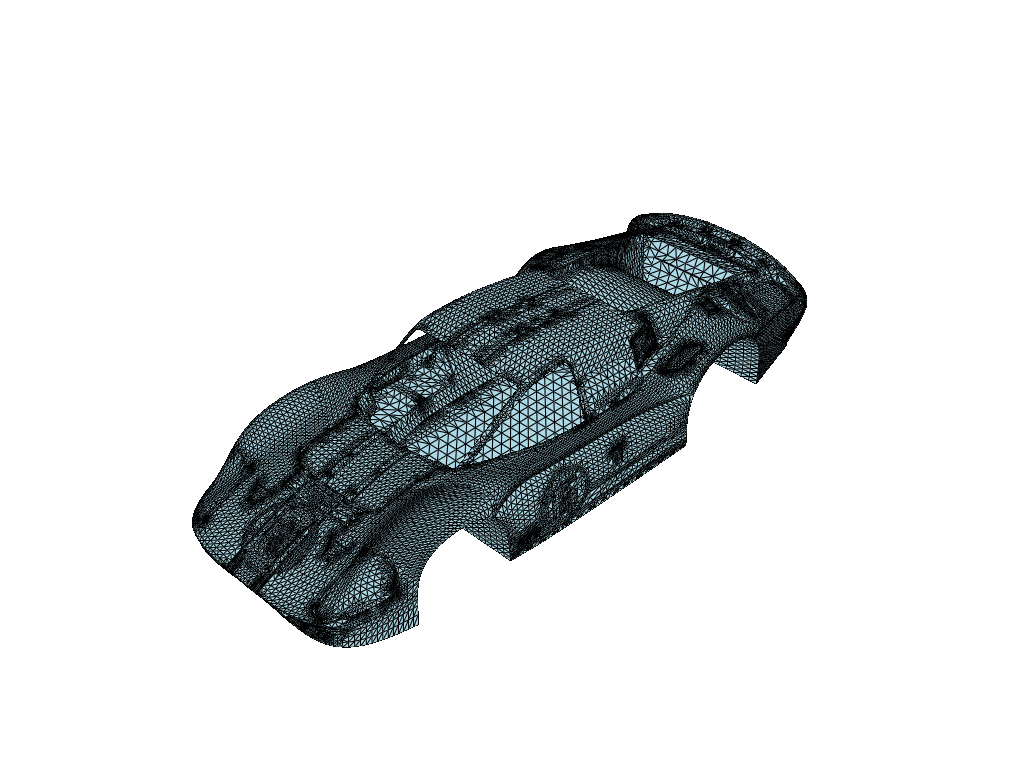

In [1]:
from sigmaepsilon.mesh import PolyData
from sigmaepsilon.mesh.downloads import download_gt40

# the 'download_gt40' function downlads a file to the local filesystem and returns
# the absolute path to the file
mesh = PolyData.read(download_gt40())

mesh.plot(notebook=True, jupyter_backend="static")

We can also read from `PyVista` instances:

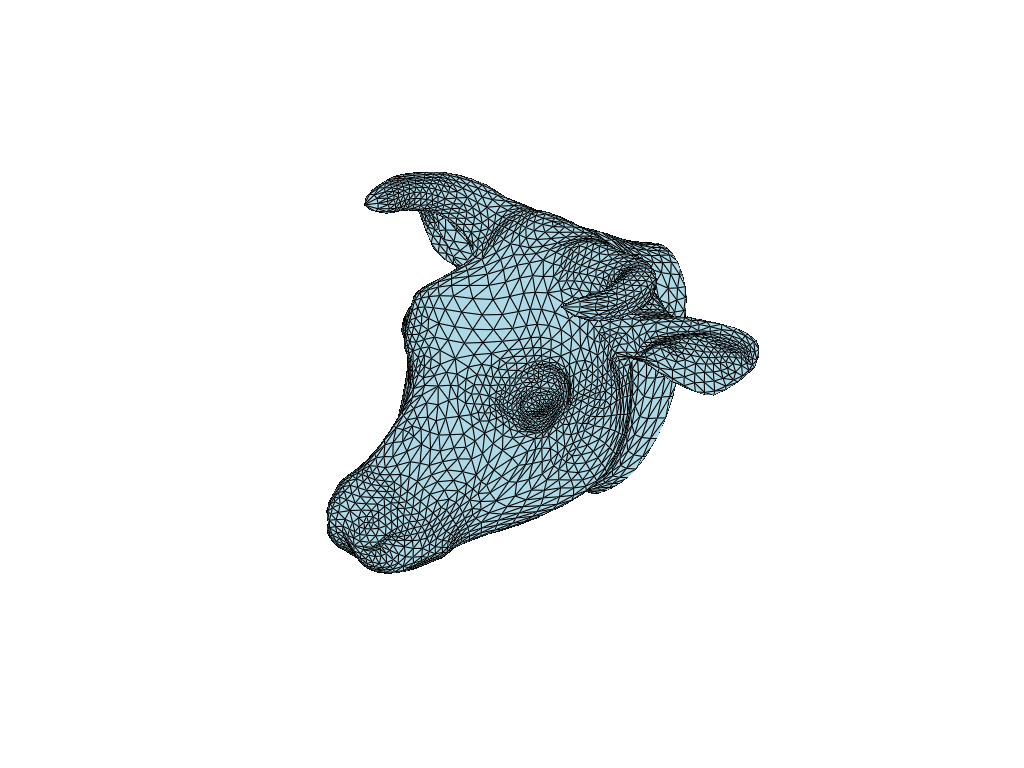

In [2]:
from sigmaepsilon.mesh import PolyData
from pyvista import examples
import math

pyvista_mesh = examples.download_cow_head()
    
mesh = PolyData.from_pv(pyvista_mesh).spin("Space", [math.pi/2, 0, 0], "xyz")
mesh.plot(notebook=True, jupyter_backend="static")

### Creating a mesh


To define a mesh is to define geometric prmitives like lines, triangles, cubes, tetrahedra, etc. There are many approaches on how to do this. The hierarchical approach is to create points (0d shapes) to define lines or other 1d shapes, use the 1d shapes to define triangles or other 2d shapes and use the 2d shapes to define cubes or other 3d shapes. This is called the _boundary representation_. In sigmaepsilon.mesh, we define a cloud of points and a set of networks or connectivity (we use the term topology) that tells abut how the individual shapes form. For example, the next block of code defines 8 points, 2 triangles, 1 quadrilateral and 2 lines.


In [115]:
import numpy as np

coords = np.array(
    [
        [0, 0, 0],
        [1, 0, 0],
        [1, 1, 0],
        [0, 1, 0],
        [2, 0, 0],
        [3, 0, 0],
        [3, 1, 0],
        [2, 1, 0],
    ],
    dtype=float,
)

triangles = np.array(
    [
        [0, 1, 2],
        [0, 2, 3],
    ],
    dtype=int,
)

quadrilaterals = np.array(
    [
        [4, 5, 6, 7],
    ],
    dtype=int,
)

lines = np.array([[1, 7], [2, 4]], dtype=int)

This is the raw data that defines a mesh. Since sigmaepsilon.mesh uses objects, we need to define the object representation of this mesh using the classes of the library. There is one class to represent points and related data (the `PointData` class), and several classes to represent cells and their related data (`T3`, `Q4` and `L2`, among many others).


In [116]:
from sigmaepsilon.mesh import PointData
from sigmaepsilon.mesh.cells import T3, Q4, L2

# data related to the points
pd = PointData(coords=coords)

# data related to 3-noded triangles
cd_triangles = T3(topo=triangles)

# data related to 4-noded quadrilaterials
cd_quadrilaterals = Q4(topo=quadrilaterals)

# data related to 2-noded lines
cd_lines = L2(topo=lines)

A mesh is collection of pointdata and celldata instances. The `PolyData` class is used to represent a mesh. The class is a subclass of the `DeepDict` class in sigmaepsilon.deepdict, we suggest to take a look at there to understand what you are dealing with, but essentially it is a nested dictionary.


In [117]:
from sigmaepsilon.mesh import PolyData

issubclass(PolyData, dict)

True

A `PolyData` instance can be created using either point-related data (coordinates and optionally other data related to the points), cell-related data (topology and optionally other data related to the cells), or both. Since the `PolyData` class is a subclass of `dict`, it inherits the behaviour, which applies to how instances can be created. Here is a simple example:


In [118]:
mesh = PolyData(pd)
mesh["triangles"] = PolyData(cd_triangles)
mesh["quads"] = PolyData(cd_quadrilaterals)
mesh["lines"] = PolyData(cd_lines)

Or this one if this is what floats your boat:


In [119]:
mesh = PolyData(
    pd,
    triangles=PolyData(cd_triangles),
    quads=PolyData(cd_quadrilaterals),
    lines=PolyData(cd_lines),
)

You can use the `asciiprint` function from `sigmaepsilon.deepdict` to print the layout of the mesh as a tree using the ASCII charatcer set. This requires the `asciitree` package to be installed.


In [120]:
from sigmaepsilon.deepdict import asciiprint

asciiprint(mesh)

PolyData
 +-- triangles
 +-- quads
 +-- lines


### Analyzing the mesh


There might be lots of things to be analysed on a mesh, depending on the scenario. The library provides the basic tools to calculate mass properties, getting the adjacency matrix, among many others. Here are some basic calculations:


In [121]:
mesh.volume()

4.82842712474619

In [122]:
mesh["triangles"].area()

0.9999999999999999

In [123]:
mesh.nodal_adjacency(frmt="scipy-csr")

<8x8 sparse array of type '<class 'numpy.intc'>'
	with 34 stored elements in Compressed Sparse Row format>

It is to be noted, that mesh analysis is not the main focus of the library and the strategy here is to provide connection to third party libraries like `scipy` and `networkx`, which have dedicated modules for this type of work. However, the library can be useful in preparing data for mesh analysis. So far you have defined topologies for lines, triangles and quadrilaterals. They all live in their respective data classes. Let say you want to implement some calculation related to the topology of the mesh. One thing the library can do for you is to get the topology of the whole mesh as one object:


In [124]:
mesh.topology()

<Array [[0, 1, 2], [0, 2, 3], ..., [1, 7], [2, 4]] type='5 * var * int32'>

In [125]:
mesh.topology().shape

(5, array([3, 3, 4, 2, 2], dtype=int64))

In [126]:
type(mesh.topology())

sigmaepsilon.mesh.topoarray.TopologyArray

The returned object is an instance of the `TopologyArray` class, which generalizes handling complex topologies. Internally it either stores a `numpy.ndarray`, or an `awkward.Array` instance, depending on the situation. Why is this good? Because both NumPy and Awkward arrays are Numba-jittable and **you can write high-performance code for their analysis, purely in Python**. If you work with `awkward.Array`s, (which is always possible in contrast to having NumPy arrays all the time), you code becomes agnostic to the complexity of the topogy and applies for all kinds of meshes, regardless of the type of cells within.


If you are interested, see more about the `TopologyArray` class in the _API Reference_.


### Visualizing the mesh


When is comes to visualization, we usually rely on `PyVista`. You will find more examples in the *User Guide*, and in the *Gallery*, but for now, we use a few simple lines. Don't worry about these lines for now, this is not the point here.

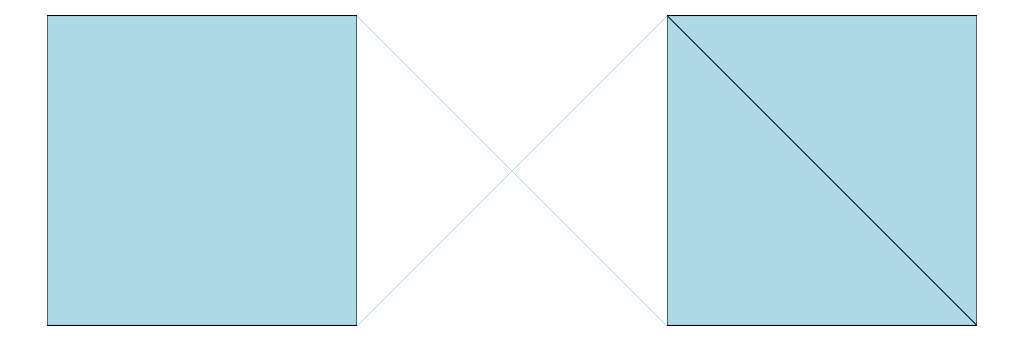

In [127]:
plotter = mesh.plot(notebook=True, theme="document", return_plotter=True)
plotter.camera.tight(padding=0.1, view="xy", negative=True)
plotter.show(jupyter_backend="static")

The point is that you can plot meshes, or parts of it using `PyVista`. If you only want to plot a submesh, you call the same method with the same arguments, but on a nested `PolyData` instance. This is where the nested dictionary arhchitecture really pays off.

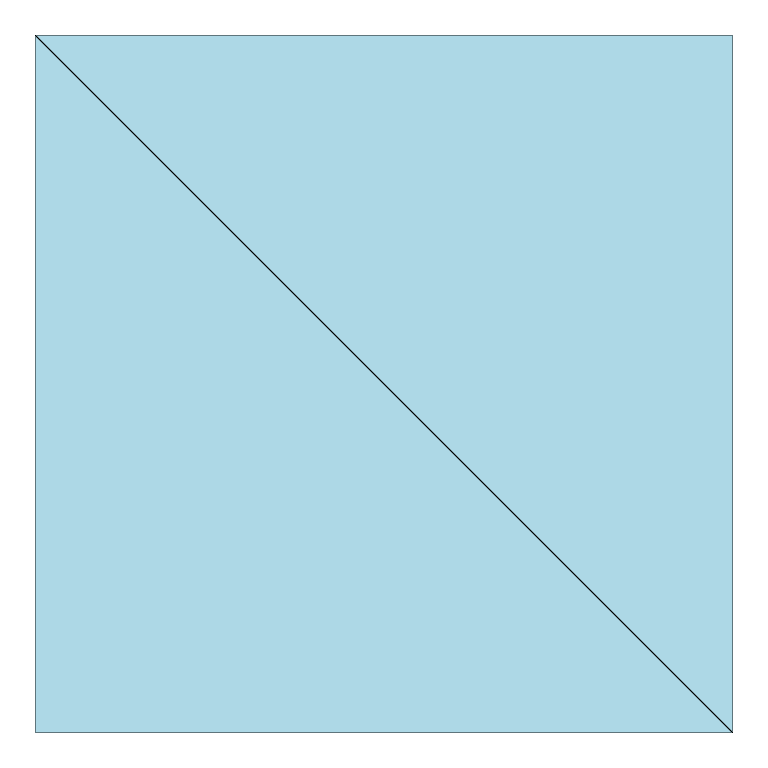

In [128]:
plotter = mesh["triangles"].plot(notebook=True, theme="document", return_plotter=True)
plotter.camera.tight(padding=0.1, view="xy", negative=True)
plotter.show(jupyter_backend="static")

### Adding data to the mesh


Assigning data to either the points or the cells is pretty easy. Every `PolyData` instance can host a `PointData` or a `CellData` class (`T3`, `Q4` and all classes in `sigmaepsion.mesh.cells` are subclasses of `CellData`), or both. These data classes wrap an `Awkward.Record`, where data is stored. For example, this is how you can assign scalars to the points of the root of the mesh (or to any `PolyData` instance that hosts a `PointData`):

In [129]:
mesh.pointdata["random_data"] = np.random.rand(coords.shape[0])

When plotting the mesh, you can specify this data using the `scalars` parameter:

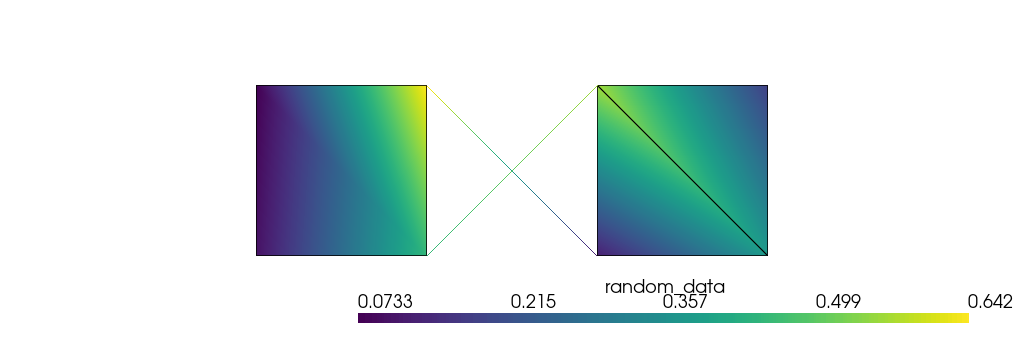

In [130]:
plotter = mesh.plot(
    notebook=True, theme="document", return_plotter=True, scalars="random_data"
)
plotter.camera.tight(padding=1, view="xy", negative=True)
plotter.show(jupyter_backend="static")

The same can be done with cell-related data. `PolyData` instances that host cells are equipped with a `celldata` property, and you can assign data to it:

In [131]:
for cb in mesh.cellblocks():
    cb.celldata["data"] = np.random.rand(cb.topology().shape[0])

Here we used the `cellblocks` method of the mesh, that yields nested `PolyData` instances that host some cells (blocks with cells -> cellblocks).

For the plot, you need data on the points. You can gather data defined on the cells and aggregate it to the points using the `pull` method of a `PointData` instance:

In [132]:
mesh.pointdata["data"] = mesh.pointdata.pull("data")

Then, plotting goes as before:

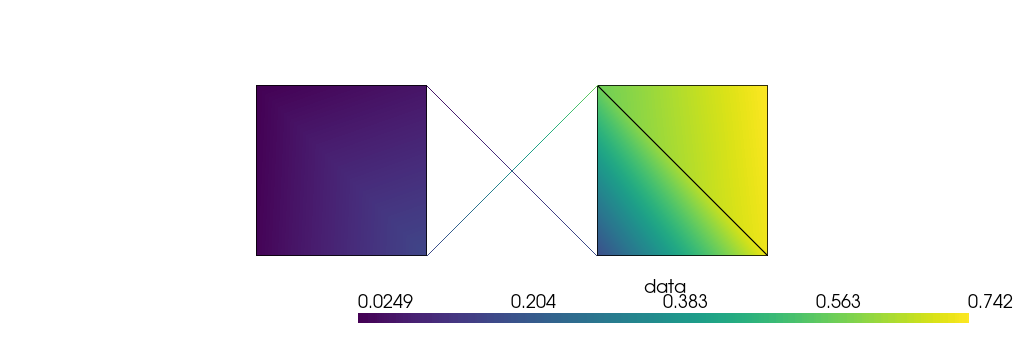

In [133]:
plotter = mesh.plot(
    notebook=True, theme="document", return_plotter=True, scalars="data"
)
plotter.camera.tight(padding=1, view="xy", negative=True)
plotter.show(jupyter_backend="static")

We assigned one scalar data to the cells. You can assign a scalar data to every point of every cell and pull that to the points:

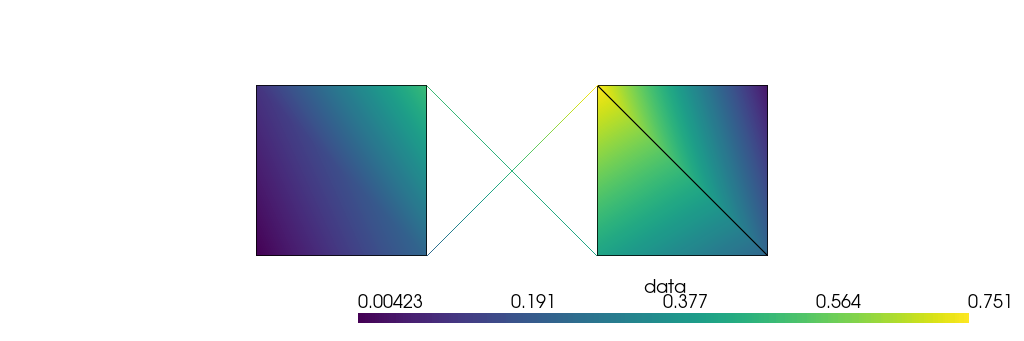

In [134]:
for cb in mesh.cellblocks():
    cb.celldata["data"] = np.random.rand(*cb.topology().shape)

mesh.pointdata["data"] = mesh.pointdata.pull("data")

plotter = mesh.plot(
    notebook=True, theme="document", return_plotter=True, scalars="data"
)
plotter.camera.tight(padding=1, view="xy", negative=True)
plotter.show(jupyter_backend="static")

The process of passing data between cells and points goes in both directions. It is pissible to define data on the points and distribute it to the nodes of the cells that meet at the points. By default, the way cell data is aggregated (or point data is distributed) is based on the volumes of the cells meeting at the nodes. This is customizable and you can find more examples in the *User Guide*.

### Exporting the mesh

Every `PointData` and `CellData` instance can be saved to a `parquet` file, or exported to popular data science formats like for instance a `Pandas.DataFrame`. To write the data to a parquet file, do this:

In [135]:
mesh.pointdata.to_parquet("pointdata.parquet")

To reconstruct from a parquet file, you do this:

In [136]:
pd = PointData.from_parquet("pointdata.parquet")

To export it as a `Pandas.DataFrame`:

In [137]:
pd.to_dataframe().tail()

_x  _activity  _id  random_data      data
entry subentry                                            
6     1         1.0       True    6     0.073275  0.116550
      2         0.0       True    6     0.073275  0.116550
7     0         2.0       True    7     0.641541  0.515709
      1         1.0       True    7     0.641541  0.515709
      2         0.0       True    7     0.641541  0.515709

For this we use the `Awkward` library, which supports many other popular data science formats, so maybe it is best to get the data as an `Awkward.Array` and then go with `Awkward`.

In [138]:
pd.to_ak()

<Array [{_x: [0, ..., 0], ...}, ..., {...}] type='8 * {_x: 3 * float64, _ac...'>

You can also export the mesh to a suitable `PyVista` instance, and you have another host of options on how to save it to popular mesh formats (through `meshio`). **It is important, that in this case data assigned to the mesh is not exported, only the mesh itself.**

In [140]:
mesh.to_pv(multiblock=True)

MultiBlock (0x18ada87b340)
  N Blocks    3
  X Bounds    0.000, 3.000
  Y Bounds    0.000, 1.000
  Z Bounds    0.000, 0.000